In [13]:
import warnings
warnings.filterwarnings('ignore')


In [14]:
import tensorflow as tf
import os

In [15]:
#Avoid OOM Errors by setting GPU Memory Consumption Growth
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
     tf.config.experimental.set_memory_growth(gpu,True)

gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [16]:
gpus = tf.config.list_physical_devices('GPU')
print(f"Number of GPUs available: {len(gpus)}")

Number of GPUs available: 1


# Data Loading

In [17]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [18]:
train_dir = 'train'
val_dir = 'test'

In [19]:
image_exts=['jpeg','jpg','bmp','png']

In [20]:
os.listdir(os.path.join(train_dir))

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

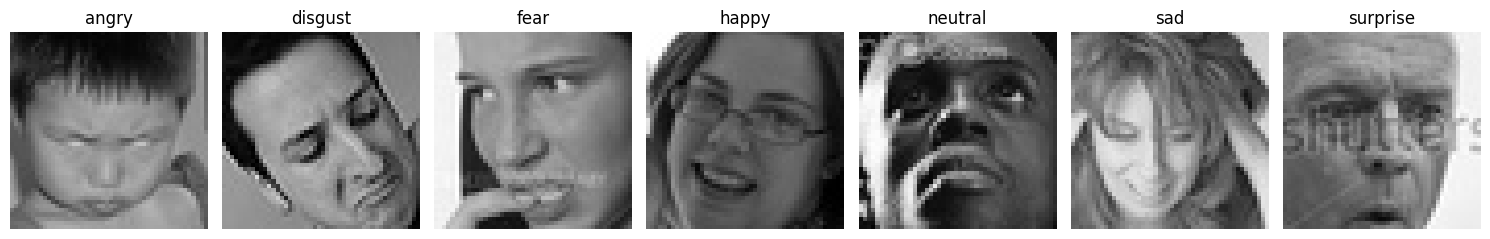

In [21]:
subclasses = sorted(os.listdir(train_dir))

plt.figure(figsize=(15, 10))

# Iterate through each subclass
for i, subclass in enumerate(subclasses):
    subclass_path = os.path.join(train_dir, subclass)

    # Get the first image file in the subclass folder
    image_name = os.listdir(subclass_path)[0]
    image_path = os.path.join(subclass_path, image_name)

    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Display the image
    plt.subplot(1, len(subclasses), i + 1)
    plt.imshow(image)
    plt.title(subclass)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Preprocessing

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [23]:
datagen_train = ImageDataGenerator(rescale = 1./255,)
datagen_val = ImageDataGenerator(rescale = 1./255,)

In [24]:
img_size = 48
batch_size = 32

train_set = datagen_train.flow_from_directory(directory=train_dir,
                                              target_size=(img_size,img_size),
                                              batch_size = batch_size,
                                              color_mode = 'grayscale',
                                              class_mode = "categorical",
                                              shuffle=True
                                              )


val_set = datagen_train.flow_from_directory(directory=val_dir,
                                              target_size=(img_size,img_size),
                                              batch_size = batch_size,
                                              color_mode = 'grayscale',
                                              class_mode = "categorical",
                                              shuffle=False
                                              )


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Deep Model

In [32]:
from keras import Input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Flatten,Dropout, BatchNormalization,GlobalAveragePooling2D,GlobalMaxPooling2D

In [33]:
model = Sequential()

In [34]:
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second layer
model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third layer
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fourth layer
model.add(Conv2D(256,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# First fully connected layer
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

# Second fully connected layer
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Dense(7, activation='softmax'))

In [35]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 6, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,726,151 (10.40 MB)

 Trainable params: 2,722,695 (10.39 MB)

 Non-trainable params: 3,456 (13.50 KB)

Train

In [36]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


In [38]:
hist = model.fit(train_set, epochs=20, validation_data=val_set, callbacks=[early_stopping,learning_rate_scheduler])

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2260 - loss: 2.2200  

2025-06-08 10:47:06.257589: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,48,48]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-08 10:47:06.293291: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,48,48]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

898/898 ━━━━━━━━━━━━━━━━━━━━ 88s 91ms/step - accuracy: 0.2261 - loss: 2.2197 - val_accuracy: 0.3651 - val_loss: 1.6362 - learning_rate: 0.0010
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 75s 84ms/step - accuracy: 0.3929 - loss: 1.5692 - val_accuracy: 0.4529 - val_loss: 1.4311 - learning_rate: 0.0010
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.4936 - loss: 1.3303 - val_accuracy: 0.4306 - val_loss: 1.4811 - learning_rate: 0.0010
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 65s 72ms/step - accuracy: 0.5439 - loss: 1.1975 - val_accuracy: 0.4299 - val_loss: 1.5335 - learning_rate: 0.0010
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.5721 - loss: 1.1312 - val_accuracy: 0.5295 - val_loss: 1.2030 - learning_rate: 0.0010
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 64s 71ms/step - accuracy: 0.5964 - loss: 1.0701 - val_accuracy: 0.5833 - val_loss: 1.1150 - learning_rate: 0.0010
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 64s 72ms/step - accuracy: 0.6189 - loss: 1.0189

In [39]:
hist.history

{'accuracy': [0.27566269040107727,
  0.423003226518631,
  0.5041624307632446,
  0.5470758080482483,
  0.5706573128700256,
  0.5901633501052856,
  0.617402195930481,
  0.6402870416641235,
  0.657180666923523,
  0.6779755353927612,
  0.7015569806098938,
  0.7181371450424194,
  0.7306419610977173,
  0.7542582750320435],
 'loss': [1.9559507369995117,
  1.4956039190292358,
  1.2996492385864258,
  1.1981651782989502,
  1.13748037815094,
  1.085250735282898,
  1.0243908166885376,
  0.9691709876060486,
  0.9195427894592285,
  0.8665226101875305,
  0.8077234029769897,
  0.7604595422744751,
  0.7318652868270874,
  0.6650933027267456],
 'val_accuracy': [0.3651435077190399,
  0.4529116749763489,
  0.43062135577201843,
  0.42992475628852844,
  0.5295346975326538,
  0.5833101272583008,
  0.5972415804862976,
  0.5932014584541321,
  0.6171635389328003,
  0.6118695735931396,
  0.6331847310066223,
  0.6327667832374573,
  0.6326274871826172,
  0.6206464171409607],
 'val_loss': [1.636205792427063,
  1.431

## plot performance


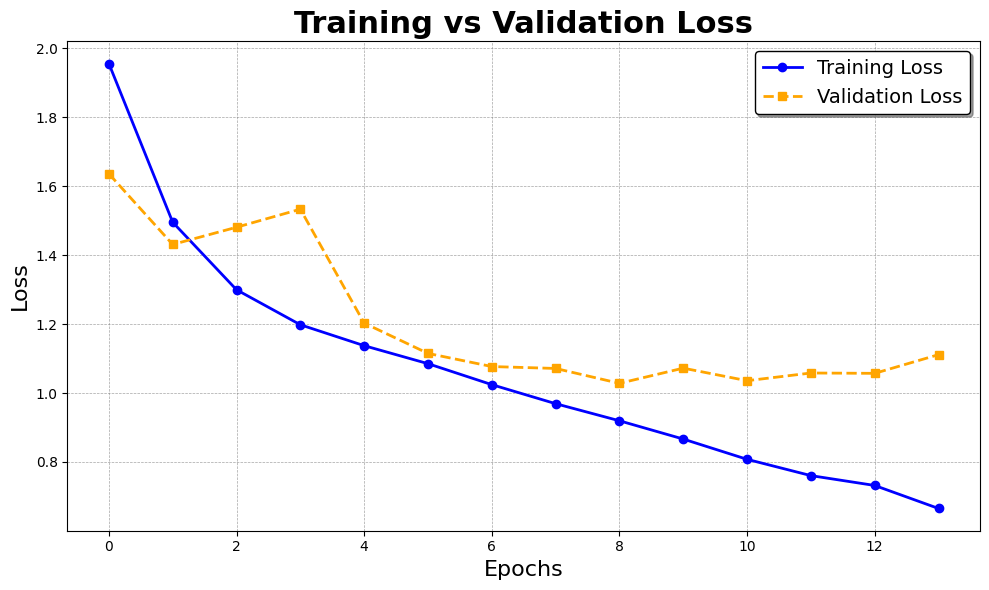

In [40]:
# Create the figure and adjust its size
fig = plt.figure(figsize=(10, 6))

# Plot the training and validation loss
plt.plot(hist.history['loss'], color='blue', label='Training Loss', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss', marker='s', linestyle='--', linewidth=2, markersize=6)

# Add title and axis labels
plt.title('Training vs Validation Loss', fontsize=22, fontweight='bold')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)

# Customize the legend
plt.legend(loc="upper right", fontsize=14, frameon=True, shadow=True, edgecolor='black')

# Add grid for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

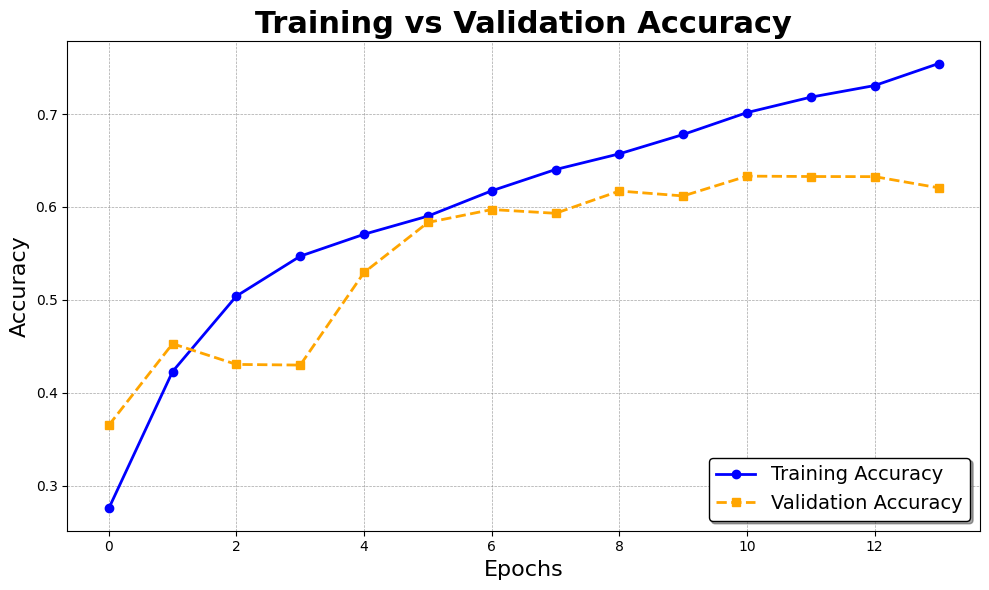

In [41]:
fig = plt.figure(figsize=(10, 6))

# Plot the training and validation accuracy
plt.plot(hist.history['accuracy'], color='blue', label='Training Accuracy', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy', marker='s', linestyle='--', linewidth=2, markersize=6)

# Add title and axis labels with improved styling
plt.title('Training vs Validation Accuracy', fontsize=22, fontweight='bold')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

# Customize the legend
plt.legend(loc="lower right", fontsize=14, frameon=True, shadow=True, edgecolor='black')

# Add grid for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot with tight layout for better spacing
plt.tight_layout()
plt.show()

# Evaluate Performance


Evaluate

In [42]:
# from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import accuracy_score

225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step


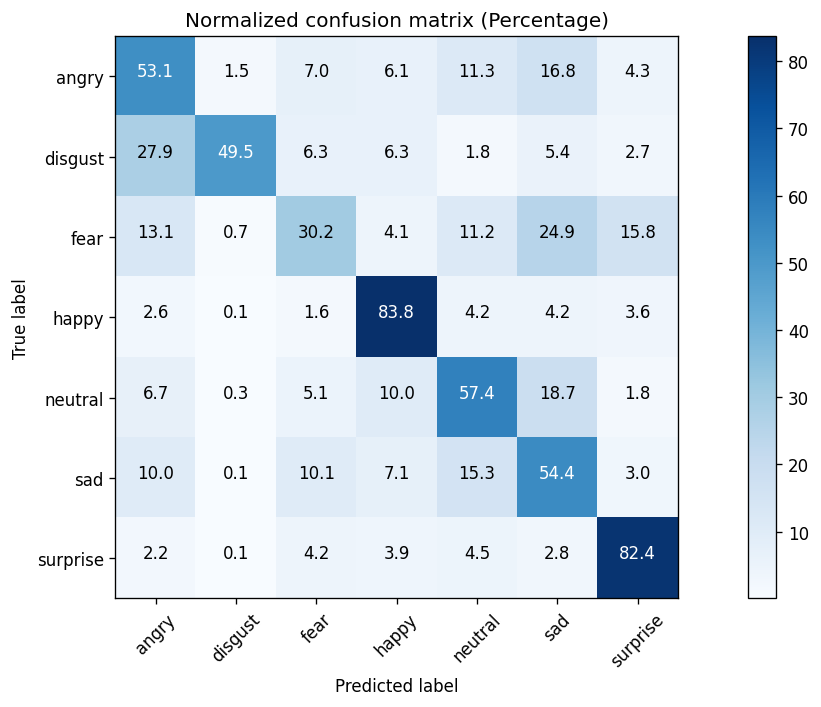

In [43]:
predictions = model.predict(val_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_set.classes
class_names = list(val_set.class_indices.keys())  # Convert to a list

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix (Percentage)', cmap=plt.cm.Blues):
    plt.figure(figsize=(12, 6), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f'  # Display percentages with 1 decimal point
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_percentage = cnf_matrix / cnf_matrix.sum(axis=1)[:, np.newaxis] * 100
np.set_printoptions(precision=1)

# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix_percentage, classes=class_names, title='Normalized confusion matrix (Percentage)')
plt.show()

In [44]:
accuracy = accuracy_score(y_test, y_pred)
correct_predictions = (y_pred == y_test).sum()
total_samples = len(y_test)
print(f"Correct Predictions: {correct_predictions}/{total_samples}")
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

Correct Predictions: 4430/7178
Testing Accuracy: 61.72%


# Save the model

In [45]:
os.makedirs('model', exist_ok=True)

# Save the model
model.save(os.path.join('model', 'CNNs_Emotion.keras'))